## **프로젝트 Summary**
---

> **프로젝트명**

```
▶ 개인화 게임 추천 시스템 구현
```  

> **유형**

```
▶ 추천 시스템 구현(Collaborative filtering)

```
> **문제정의**

```
▶ 게임산업의 다양화되고 복잡화되면서 사용자들이 취향에 맞는 게임을 찾기 어려움
```  

> **기대효과**

```
▶ 추천시스템을 적용해 사용자들에게 사용자들이 좋아할 만한 게임들을 추천함으로써 최상의 게임 경험을 제공할 수 있음
```

> **해결방안**

```
▶ 개인화 게임 추천 알고리즘 설계
```

> **성과측정**  

```
▶ 만들어진 추천 시스템을 직접 사용자에게 노출시켜서 사용자의 반응을 수집해서 평가,
혹은 사용자의 게임 선호 기록과 추천 시스템이 추천한 결과를 비교해서 평가.
```

> **데이터 살펴보기**


|Column|Description|
|:---|:---|
|UserID|유저 아이디|
|Game|게임 타이틀|
|Action|구매/플레이|
|Hours|플레이시간|
|Other|기타|

* Hours : Hours if behavior is play, 1.0 if behavior is purchase





In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
# drive.mount('/content/drive')
%cd '/content/drive/MyDrive/개인 공부/개인화 게임 추천 시스템 구현[*]'

In [ ]:
df = pd.read_csv('P_PJT08_DATA.csv')
df.head()

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [ ]:
# 추천 알고리즘의 종류
# Knowledge based filtering : 추천하고자 하는 분야의 도메인 지식을 활용해 추천하는 방식. ex) 성별, 연령별 많이 팔리는 상품 추천.
# content based filtering : 추천하려는 아이템의 콘텐츠 정보를 분석하거나 정리된 메타데이터로 콘텐츠별 특징 정보를 만들고, 이를 활용해 추천하는 방식. ex) 상품 페이지 하단 동일 카테고리의 인기제품 추천.
# collaborative filtering : 소비자들의 소비 이력을 바탕으로 소비하지 않은 새로운 아이템 추천. ex) 클릭 기록을 바탕으로 소비자가 다음으로 클릭할 만한 제품 추천.

# 추천 알고리즘 평가 방법
# 1. 오프라인 평가 방법 : 사용자의 아이템에 대한 선호 기록과 추천 시스템이 추천한 결과를 비교해서, 시스템의 품질 평가
# 특징 : 비용지출 없음, 여러 모델 동시평가 가능, 실제 사용자의 만족도가 평가 결과와 다를 수 있음.

# 2. 온라인 평가 방법 : 만들어진 추천 시스템을 직접 사용자에게 노출시켜서 사용자의 반응을 수집해서 평가
# 실제 사용자의 만족도를 측정하기 때문에 정확한 방식이다. 그러나 비용이 비싸다( ex. 사용자의 만족도가 감소할 가능성이 있음)

# 데이터 출처 : https://www.kaggle.com/datasets/tamber/steam-video-games/code

# 갖고 있는 데이터는 유저들이 플레이한 게임, 플레이 시간, 장르 등의 정보이므로 collaborative filtering 기법으로 추천시스템을 만들 것이다.

## EDA, 전처리

In [ ]:
df.info()

# 20만 행의 데이터. 결측치 없음
# 컬럼은 유저id, 게임 이름, 해당 게임에 대한 액션(샀는지, 플레이했는지), 플레이 시간, Other

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   UserID  200000 non-null  int64  
 1   Game    200000 non-null  object 
 2   Action  200000 non-null  object 
 3   Hours   200000 non-null  float64
 4   Other   200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [ ]:
# 유저 수와 게임 수는 각각 얼마일까?
print(df['UserID'].nunique())
print(df['Game'].nunique())

# 유저는 12393명, 게임은 5155개.

12393
5155


In [ ]:
# Action은 무엇무엇이 있는가?
print(df['Action'].unique())

# 구매와 플레이 2가지가 있다.

# 그렇다면 20만건 중 구매와 플레이 수 차이는?
print(df['Action'].value_counts())

# 20만건 중 약 13만건이 구매, 나머지 7만건이 플레이. 약 2배가량 차이난다.

['purchase' 'play']
purchase    129511
play         70489
Name: Action, dtype: int64


In [ ]:
# Hours는 플레이 시간인데 Action이 purchase인 행에는 어떤 값이 들어있을지?
df[df['Action'] == 'purchase']['Hours'].unique()

# action이 '구매'인 경우, 플레이 시간은 전부 1시간으로 되어 있다.
# 플레이 없이 구매만 한 것도 '선호도'가 있는 것으로 판단할 수 있으므로, 그냥 두도록 하자.

array([1.])

In [ ]:
# 플레이 시간의 분포는?
100*df['Hours'].value_counts(normalize=True).sort_values(ascending=False)

# 1시간이 압도적으로 많다.
# 구매만 있어도 1시간인데, 플레이랑 구매 둘 중 무엇이 더 많은가?

1.0       65.2845
0.2        1.5080
0.3        1.2585
0.4        1.0645
0.5        0.9065
           ...   
3085.0     0.0005
3590.0     0.0005
538.0      0.0005
2086.0     0.0005
1310.0     0.0005
Name: Hours, Length: 1593, dtype: float64

In [ ]:
one_hour = df[df['Hours'] == 1]
one_hour['Action'].value_counts()

# 구매가 12만 9천건, 1시간 플레이는 1000건.
# 1시간만 플레이했다는건 그만큼 게임이 재미 없었다는 것으로 판단할 수 있을까?
# 1시간 이하 플레이타임은?
# 등등의 의문이 따라오기 때문에, play_hours라는 컬럼을 따로 만들기로 한다.

purchase    129511
play          1058
Name: Action, dtype: int64

In [ ]:
df['play_hours'] = df['Hours']

# action이 purchase고 Hours가 1시간인 경우 'play_hours' 컬럼의 값에 0 할당.
df.loc[(df['Action'] == 'purchase') & (df['Hours'] == 1.0), 'play_hours'] = 0
df

,UserID,Game,Action,Hours,Other,play_hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0,0.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0,273.0
2,151603712,Fallout 4,purchase,1.0,0,0.0
3,151603712,Fallout 4,play,87.0,0,87.0
4,151603712,Spore,purchase,1.0,0,0.0
...,...,...,...,...,...,...
199995,128470551,Titan Souls,play,1.5,0,1.5
199996,128470551,Grand Theft Auto Vice City,purchase,1.0,0,0.0
199997,128470551,Grand Theft Auto Vice City,play,1.5,0,1.5
199998,128470551,RUSH,purchase,1.0,0,0.0


In [ ]:
# other 컬럼은 무슨 컬럼인가?

print(df.Other.unique())

# 모든 값이 0이다. 없어도 될 컬럼이므로 삭제하고, play_hours 컬럼도 만들었으니 Action 컬럼도 삭제하자.
df.drop(['Other', 'Action'], axis=1, inplace=True)
df

[0]


,UserID,Game,Hours,play_hours
0,151603712,The Elder Scrolls V Skyrim,1.0,0.0
1,151603712,The Elder Scrolls V Skyrim,273.0,273.0
2,151603712,Fallout 4,1.0,0.0
3,151603712,Fallout 4,87.0,87.0
4,151603712,Spore,1.0,0.0
...,...,...,...,...
199995,128470551,Titan Souls,1.5,1.5
199996,128470551,Grand Theft Auto Vice City,1.0,0.0
199997,128470551,Grand Theft Auto Vice City,1.5,1.5
199998,128470551,RUSH,1.0,0.0


In [ ]:
display(df)
print('='*150)

# 지금 data의 play_hours에는 구매만 한 경우(play_hours == 0인 데이터)와 구매+플레이까지 한 경우(play_hours == 0인 데이터 + play_hours > 0인 데이터)가 섞여 있다.
# 어떤 게임을 플레이했다는 것은 당연히 구매도 했다는 것이므로, 구매+플레이한 경우엔 구매만 한 경우의 데이터를 없애고 싶다. 별 필요 없으니까.

# 유저별 게임명이 중복되는것을 없애면 될 듯.
# 없애고 난 후엔 Hours 컬럼도 필요 없다. play_hours가 0이면 구매만 한 경우고 0이상이면 구매 + 해당 값의 시간만큼 플레이한 경우니까.
# 구매 데이터가 먼저 오니까 아래와 같이 코드를 실행시킨다.

clean_df = df.drop_duplicates(['UserID', 'Game'], keep = 'last').drop('Hours', axis = 1)
clean_df

,UserID,Game,Hours,play_hours
0,151603712,The Elder Scrolls V Skyrim,1.0,0.0
1,151603712,The Elder Scrolls V Skyrim,273.0,273.0
2,151603712,Fallout 4,1.0,0.0
3,151603712,Fallout 4,87.0,87.0
4,151603712,Spore,1.0,0.0
...,...,...,...,...
199995,128470551,Titan Souls,1.5,1.5
199996,128470551,Grand Theft Auto Vice City,1.0,0.0
199997,128470551,Grand Theft Auto Vice City,1.5,1.5
199998,128470551,RUSH,1.0,0.0


,UserID,Game,play_hours
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9
...,...,...,...
199991,128470551,Fallen Earth,2.4
199993,128470551,Magic Duels,2.2
199995,128470551,Titan Souls,1.5
199997,128470551,Grand Theft Auto Vice City,1.5


In [ ]:
# 유저 수와 게임 수가 변했을까?
print(df['UserID'].nunique())
print(df['Game'].nunique())
print('='*50)

print(clean_df['UserID'].nunique())
print(clean_df['Game'].nunique())

# 그대로다.

12393
5155
12393
5155


In [ ]:
# 유저 한명당 몇개의 게임을 구매 or 구매+플레이 했을까?

np.mean(clean_df.groupby('UserID')['Game'].count())
# 평균적으로 10개 정도다.

10.393286532720085

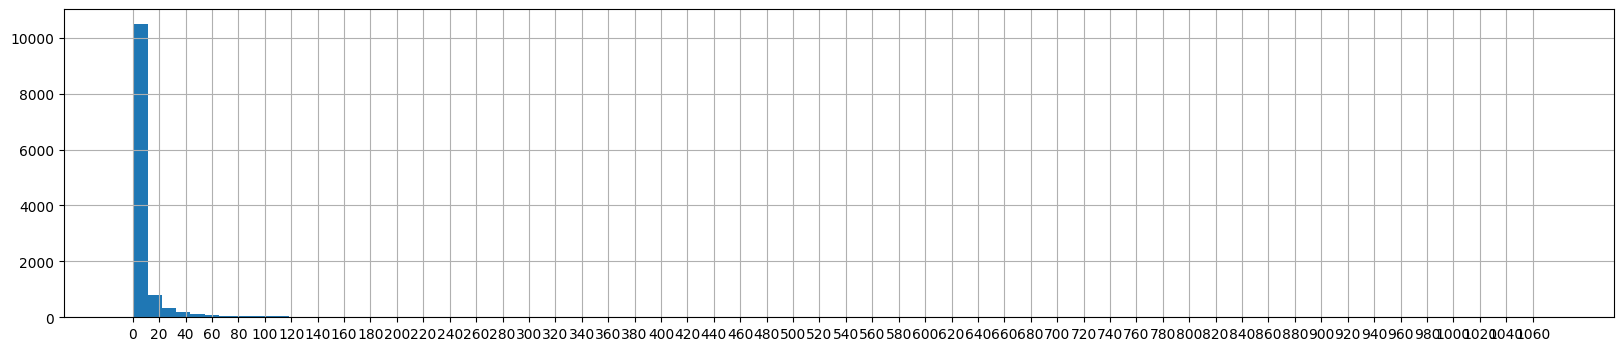

2.0


In [ ]:
# 분포는?
games_per_user = clean_df.groupby('UserID')['Game'].count()

plt.figure(figsize=(20,4))
plt.xticks(np.arange(0, games_per_user.max(), 20))
games_per_user.hist(bins = 100)
plt.show()
print('='*100)

# 대부분이 10~20에 몰려있다.
# 위에서 평균으로 유저 한명당 구매 or 구매+플레이 한 게임 수를 구했었는데, 중앙값이 더 정확할 듯 싶다.
print(np.median(clean_df.groupby('UserID')['Game'].count()))

# 2개다

## 유저별 게임 추천 알고리즘(Collaborative filtering)

### user profile 만들기

In [ ]:
# 유저들이 어떤 게임을 얼마나 플레이했는지를 나타내는 user profile을 만들어 본다.

user_profile = clean_df.pivot_table(index='UserID', columns='Game').fillna(0)
user_profile

play_hours            \
Game      007 Legends 0RBITALIS   
UserID                            
5250              0.0       0.0   
76767             0.0       0.0   
86540             0.0       0.0   
103360            0.0       0.0   
144736            0.0       0.0   
...               ...       ...   
309554670         0.0       0.0   
309626088         0.0       0.0   
309812026         0.0       0.0   
309824202         0.0       0.0   
309903146         0.0       0.0   

                                                                      \
Game      1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)   
UserID                                                                 
5250                                                     0.0           
76767                                                    0.0           
86540                                                    0.0           
103360                                                   0.0           
144736                                                   0.0           
...                                                      ...           
309554670                                                0.0           
309626088                                                0.0           
309812026                                                0.0           
309824202                                                0.0           
309903146                                                0.0           

                                                                  \
Game      10 Second Ninja 10,000,000 100% Orange Juice 1000 Amps   
UserID                                                             
5250                  0.0        0.0               0.0       0.0   
76767                 0.0        0.0               0.0       0.0   
86540                 0.0        0.0               0.0       0.0   
103360                0.0        0.0               0.0       0.0   
144736                0.0        0.0               0.0       0.0   
...                   ...        ...               ...       ...   
309554670             0.0        0.0               0.0       0.0   
309626088             0.0        0.0               0.0       0.0   
309812026             0.0        0.0               0.0       0.0   
309824202             0.0        0.0               0.0       0.0   
309903146             0.0        0.0               0.0       0.0   

                                                                            \
Game      12 Labours of Hercules 12 Labours of Hercules II The Cretan Bull   
UserID                                                                       
5250                         0.0                                       0.0   
76767                        0.0                                       0.0   
86540                        0.0                                       0.0   
103360                       0.0                                       0.0   
144736                       0.0                                       0.0   
...                          ...                                       ...   
309554670                    0.0                                       0.0   
309626088                    0.0                                       0.0   
309812026                    0.0                                       0.0   
309824202                    0.0                                       0.0   
309903146                    0.0                                       0.0   

                                                 ...                     \
Game      12 Labours of Hercules III Girl Power  ... rFactor 2 realMyst   
UserID                                           ...                      
5250                                        0.0  ...       0.0      0.0   
76767                                       0.0  ...       0.0      0.0   
86540                                       0.0  ...       0.0      0.0   
103360         

In [ ]:
# user profile을 matrix로 만들자.

user_profile_matrix = user_profile.values   # 예전엔 as_matrix()가 쓰였으나 이젠 쓰이지 않고 .values가 그 자리를 대신함.
user_profile_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
len(user_profile_matrix)

12393

In [ ]:
np.mean(user_profile_matrix[0])

0.0437439379243453

In [ ]:
user_profile_mean = np.mean(user_profile_matrix, axis=1)
len(user_profile_mean)

12393

In [ ]:
user_profile_mean = np.mean(user_profile_matrix, axis=1)
matrix_user_mean = user_profile_matrix - user_profile_mean.reshape(-1,1)
matrix_user_mean

array([[-4.37439379e-02, -4.37439379e-02, -4.37439379e-02, ...,
        -4.37439379e-02, -4.37439379e-02, -4.37439379e-02],
       [-2.38021339e-01, -2.38021339e-01, -2.38021339e-01, ...,
        -2.38021339e-01, -2.38021339e-01, -2.38021339e-01],
       [-4.94665373e-02, -4.94665373e-02, -4.94665373e-02, ...,
        -4.94665373e-02, -4.94665373e-02, -4.94665373e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.35790495e-04, -1.35790495e-04, -1.35790495e-04, ...,
        -1.35790495e-04, -1.35790495e-04, -1.35790495e-04],
       [-3.87972842e-05, -3.87972842e-05, -3.87972842e-05, ...,
        -3.87972842e-05, -3.87972842e-05, -3.87972842e-05]])

In [ ]:
matrix_user_mean.shape

(12393, 5155)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(matrix_user_mean, k = 12)

In [ ]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(12393, 12)
(12,)
(12, 5155)


In [ ]:
# sigma 모양 맞춰주기
sigma = np.diag(sigma)
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(12393, 12)
(12, 12)
(12, 5155)


In [ ]:
sigma

array([[ 5064.40079494,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,  5110.92132756,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  5453.65406704,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,  5541.72747292,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
         5797.95486227,     0.        ,     0.        ,     

In [ ]:
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_profile_mean.reshape(-1, 1)
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns=user_profile.columns, index=user_profile.index)
df_svd_preds.head()

play_hours                \
Game     007 Legends     0RBITALIS   
UserID                               
5250    4.119215e-02  4.118974e-02   
76767   9.235563e-02  9.222170e-02   
86540  -4.377869e-02 -4.381034e-02   
103360 -1.806648e-16 -1.807788e-16   
144736 -9.217915e-08 -9.455903e-08   

                                                                   \
Game   1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)   
UserID                                                              
5250                                         4.130812e-02           
76767                                        9.558654e-02           
86540                                       -4.047593e-02           
103360                                      -1.755524e-16           
144736                                       1.406770e-07           

                                                                      \
Game   10 Second Ninja    10,000,000 100% Orange Juice     1000 Amps   
UserID                                                                 
5250      4.120948e-02  4.125984e-02      4.121403e-02  4.118835e-02   
76767     9.253526e-02  9.353122e-02      8.947926e-02  9.221175e-02   
86540    -4.353263e-02 -3.972713e-02     -4.304052e-02 -4.384007e-02   
103360   -1.781470e-16 -1.775466e-16     -1.681263e-16 -1.809982e-16   
144736   -8.832579e-08 -9.149938e-08     -4.194099e-07 -9.279847e-08   

                                                                         \
Game   12 Labours of Hercules 12 Labours of Hercules II The Cretan Bull   
UserID                                                                    
5250             4.137169e-02                              4.137788e-02   
76767            1.086467e-01                              9.496130e-02   
86540           -3.452556e-02                             -3.468829e-02   
103360          -1.888411e-16                             -1.801093e-16   
144736           3.451408e-06                             -3.850139e-07   

                                              ...                              \
Game   12 Labours of Hercules III Girl Power  ...     rFactor 2      realMyst   
UserID                                        ...                               
5250                            4.136405e-02  ...  4.118842e-02  4.118877e-02   
76767                           9.456723e-02  ...  9.222021e-02  9.221843e-02   
86540                          -3.598544e-02  ... -4.383824e-02 -4.381464e-02   
103360                         -1.812834e-16  ... -1.809736e-16 -1.808363e-16   
144736                         -4.043238e-07  ... -9.272760e-08 -9.276561e-08   

                                                                   \
Game   realMyst Masterpiece Edition resident evil 4 / biohazard 4   
UserID                                                              
5250                   4.125335e-02                  4.173315e-02   
76767                  9.356980e-02                  9.807483e-02   
86540                 -3.995172e-02                 -1.721511e-02   
103360                -1.747911e-16                 -1.840452e-16   
144736                -8.728829e-08                 -9.604447e-07   

                                                                            \
Game      rymdkapsel  sZone-Online  samurai_jazz the static speaks my name   
UserID                                                                       
5250    4.118817e-02  4.124479e-02  4.118803e-02              4.119290e-02   
76767   9.220471e-02  9.448380e-02  9.220538e-02              9.230892e-02   
86540  -4.384918e-02 -4.120800e-02 -4.385641e-02             -4.356893e-02   
103360 -1.808603e-16 -1.851511e-16 -1.810177e-16             -1.809472e-16   
144736 -9.271372e-08  3.796541e-07 -9.272852e-08             -9.019078e-08   

                                       
Game       theHunter theHunter Primal  
UserID                                 
5250    4.193512e-02     4.

### 유저별 게임추천 알고리즘

In [ ]:
user_id = 151603712

# 위 유저가 구매 or 구매+플레이한 게임
print(f"{user_id} 유저가 구매 or 구매+플레이한 게임 : \n{clean_df[clean_df['UserID'] == user_id]['Game']}")

151603712 유저가 구매 or 구매+플레이한 게임 : 
1                      The Elder Scrolls V Skyrim
3                                       Fallout 4
5                                           Spore
7                               Fallout New Vegas
9                                   Left 4 Dead 2
11                                       HuniePop
13                                  Path of Exile
15                                    Poly Bridge
17                                    Left 4 Dead
19                                Team Fortress 2
21                                    Tomb Raider
23                                The Banner Saga
25                           Dead Island Epidemic
27                              BioShock Infinite
29          Dragon Age Origins - Ultimate Edition
31           Fallout 3 - Game of the Year Edition
33             SEGA Genesis & Mega Drive Classics
35                            Grand Theft Auto IV
37                           Realm of the Mad God
39              

In [ ]:
# 해당 유저의 게임 별 예상 플레이타임
user_predictions = df_svd_preds.loc[user_id].sort_values(ascending=False)
user_predictions

            Game                                       
play_hours  The Elder Scrolls V Skyrim                     219.214784
            FINAL FANTASY XIV A Realm Reborn                67.578879
            Call of Duty Modern Warfare 2 - Multiplayer     44.321297
            Left 4 Dead 2                                   27.449404
            Borderlands 2                                   25.860942
                                                              ...    
            Europa Universalis IV                           -1.097759
            Counter-Strike Global Offensive                 -1.618776
            Football Manager 2014                           -1.963364
            Garry's Mod                                     -4.992809
            APB Reloaded                                   -16.736569
Name: 151603712, Length: 5155, dtype: float64

In [ ]:
# 해당 유저가 이미 구매 or 구매 + 플레이한 게임 제외하기
played_games = clean_df[clean_df['UserID'] == user_id]['Game'].unique()

user_predictions = user_predictions.loc[~user_predictions.index.get_level_values('Game').isin(played_games)]

# 예상 플레이시간 Top10을 추천한다.
user_predictions[:10]

            Game                                       
play_hours  FINAL FANTASY XIV A Realm Reborn               67.578879
            Call of Duty Modern Warfare 2 - Multiplayer    44.321297
            Borderlands 2                                  25.860942
            Warframe                                       24.407466
            Terraria                                       21.673729
            Baldur's Gate II Enhanced Edition              20.537242
            Call of Duty Modern Warfare 3 - Multiplayer    17.924519
            Arma 3                                         15.902009
            Total War ROME II - Emperor Edition            15.260628
            Call of Duty Black Ops - Multiplayer           14.856092
Name: 151603712, dtype: float64

In [ ]:
# MultiIndex를 단일 인덱스로 변환
user_predictions_df = user_predictions[:10].reset_index()

# 컬럼명 변경
user_predictions_df = user_predictions_df[['Game', user_id]]
user_predictions_df.rename(columns={user_id : 'recommendation_score'}, inplace=True)


# 추천 게임.
user_predictions_df

,Game,recommendation_score
0,FINAL FANTASY XIV A Realm Reborn,67.578879
1,Call of Duty Modern Warfare 2 - Multiplayer,44.321297
2,Borderlands 2,25.860942
3,Warframe,24.407466
4,Terraria,21.673729
5,Baldur's Gate II Enhanced Edition,20.537242
6,Call of Duty Modern Warfare 3 - Multiplayer,17.924519
7,Arma 3,15.902009
8,Total War ROME II - Emperor Edition,15.260628
9,Call of Duty Black Ops - Multiplayer,14.856092


In [ ]:
# 위의 과정들을 함수로 만들어보자.

def recommendation(df_svd_preds, user_id, clean_df, num_recommendations=10):
    user_predictions = df_svd_preds.loc[user_id].sort_values(ascending=False)

    played_games = clean_df[clean_df['UserID'] == user_id]['Game'].unique()

    user_play_history = clean_df[clean_df['UserID'] == user_id]

    user_predictions = user_predictions.loc[~user_predictions.index.get_level_values('Game').isin(played_games)]
    user_predictions_df = user_predictions[:num_recommendations].reset_index()

    user_predictions_df = user_predictions_df[['Game', user_id]]
    user_predictions_df.rename(columns={user_id : 'recommendation_score'}, inplace=True)

    return user_play_history, user_predictions_df

In [ ]:
# 활용 예시. 유저 76767의 플레이 기록과 추천게임 도출하기.
play_history, game_recommendation = recommendation(df_svd_preds, 76767, clean_df, 10)

In [ ]:
# 유저 76767의 게임 플레이 기록. 상위 10개 게임.
play_history.head(10)

,UserID,Game,play_hours
55915,76767,Counter-Strike,365.0
55917,76767,Call of Duty World at War,271.0
55919,76767,Total War ATTILA,207.0
55921,76767,Call of Duty Modern Warfare 2 - Multiplayer,165.0
55923,76767,Call of Duty Modern Warfare 2,65.0
55925,76767,Counter-Strike Source,25.0
55927,76767,Banished,24.0
55929,76767,Call of Duty Black Ops,22.0
55931,76767,Call of Duty Modern Warfare 3,15.9
55933,76767,Portal 2,15.0


In [ ]:
# 유저 76767에게 추천하는 게임 리스트 Top10
game_recommendation

,Game,recommendation_score
0,APB Reloaded,45.326499
1,The Elder Scrolls V Skyrim,32.291671
2,Mount & Blade Warband,13.789741
3,Call of Duty Black Ops II - Multiplayer,9.052175
4,Empire Total War,7.263448
5,Total War ROME II - Emperor Edition,7.172696
6,Total War SHOGUN 2,5.746531
7,Left 4 Dead 2,5.638585
8,Warframe,4.722371
9,Clicker Heroes,4.665358
